In [1]:
import random
import pandas as pd
import numpy as np
import os
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder


import warnings
warnings.filterwarnings(action='ignore') 
korea_holidays = holidays.SouthKorea(years=2023)
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [131]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')
m1 = pd.read_csv('./open/external_open/대구 CCTV 정보.csv',encoding='cp949')
m2 = pd.read_csv('./open/external_open/대구 보안등 정보.csv',encoding='cp949')
m3 = pd.read_csv('./open/external_open/대구 어린이 보호 구역 정보.csv',encoding='cp949')
m4 = pd.read_csv('./open/external_open/대구 주차장 정보.csv',encoding='cp949')
train[['사망자수','중상자수','경상자수','부상자수','ECLO']]

,사망자수,중상자수,경상자수,부상자수,ECLO
0,0,1,0,0,5
1,0,0,1,0,3
2,0,0,1,0,3
3,0,1,0,0,5
4,0,0,1,0,3
...,...,...,...,...,...
39604,0,0,1,0,3
39605,0,0,1,0,3
39606,0,2,0,0,10
39607,0,0,1,0,3


In [140]:
tp = train[['사망자수','중상자수','경상자수','부상자수','ECLO']]
tp['탑승자'] = tp['사망자수'] + tp['중상자수'] + tp['경상자수'] + tp['부상자수']
tp

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 tp = train[['사망자수','중상자수','경상자수','부상자수','ECLO']]                             │
│ ❱ 2 tp[['탑승자']] = tp[['사망자수']] # + tp['중상자수'] + tp['경상자수'] + tp['부상자수']       │
│   3 tp                                                                                           │
│   4                                                                                              │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\pandas\core\frame.py:3968 in __setitem__  │
│                                                                                                  │
│    3965 │   │   if isinstance(key, DataFrame) or getattr(key, "ndim", None) == 2:                │
│    3966 │   │   │   self._setitem_frame(key, value)                                              │
│    3967 │   │   elif isinstance(key, (Series, np.ndarray, list, Index)):                         │
│ ❱  3968 │   │   │   self._setitem_array(key, value)                                              │
│    3969 │   │   elif isinstance(value, DataFrame):                                               │
│    3970 │   │   │   self._set_item_frame_value(key, value)                                       │
│    3971 │   │   elif (                                                                           │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\pandas\core\frame.py:4012 in              │
│ _setitem_array                                                                                   │
│                                                                                                  │
│    4009 │   │   │   if isinstance(value, DataFrame):                                             │
│    4010 │   │   │   │   check_key_length(self.columns, key, value)                               │
│    4011 │   │   │   │   for k1, k2 in zip(key, value.columns):                                   │
│ ❱  4012 │   │   │   │   │   self[k1] = value[k2]                                                 │
│    4013 │   │   │                                                                                │
│    4014 │   │   │   elif not is_list_like(value):                                                │
│    4015 │   │   │   │   for col in key:                                                          │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\pandas\core\frame.py:3980 in __setitem__  │
│                                                                                                  │
│    3977 │   │   │   self._setitem_array([key], value)                                            │
│    3978 │   │   else:                                                                            │
│    3979 │   │   │   # set column                                                                 │
│ ❱  3980 │   │   │   self._set_item(key, value)                                                   │
│    3981 │                                                                                        │
│    3982 │   def _setitem_slice(self, key: slice, value):                                         │
│    3983 │   │   # NB: we can't just use self.loc[key] = value because that                       │
│                                                                                                  │
│ C:\Users\User\anaconda3\envs\project\lib\site-packages\pandas\core\frame.py:4187 in _set_item 

In [39]:
# cols = list(test.columns)
# cols.append('ECLO')
# train = train[cols]
# print(train.info())
# train

- regression or sequential and featrue engieneering

In [42]:
print(train['사망자수'].value_counts())
print(train['중상자수'].value_counts())
print(train['경상자수'].value_counts())
print(train['부상자수'].value_counts())


0    39309
1      292
2        8
Name: 사망자수, dtype: int64
0    30136
1     8724
2      618
3       98
4       28
5        4
6        1
Name: 중상자수, dtype: int64
1     20913
0     10284
2      5560
3      1728
4       732
5       259
6        77
7        32
8         7
9         7
10        2
15        2
14        1
11        1
12        1
18        1
13        1
22        1
Name: 경상자수, dtype: int64
0     35168
1      4046
2       279
3        67
4        35
5         9
6         3
7         1
10        1
Name: 부상자수, dtype: int64


In [246]:
light_df = pd.read_csv('./open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])
light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

child_area_df = pd.read_csv('./open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()# [['소재지지번주소']]
child_area_df['시설수'] = 1
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

parking_df = pd.read_csv('./open/external_open/대구 주차장 정보.csv', encoding='cp949')
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
parking_df = parking_df.groupby(['도시', '구', '동']).mean().reset_index()
parking_df.reset_index(inplace=True, drop=True)
parking_df = parking_df.fillna(0)

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')
cols = list(test.columns)
cols.append('ECLO')
train = train[cols]

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 
train[['연', '월', '일', '시간']] = train['사고일시'].str.extract(time_pattern)
train[['연', '월', '일', '시간']] = train[['연', '월', '일', '시간']].apply(pd.to_numeric) 
train = train.drop(columns=['사고일시'])
test[['연', '월', '일', '시간']] = test['사고일시'].str.extract(time_pattern)
test[['연', '월', '일', '시간']] = test[['연', '월', '일', '시간']].apply(pd.to_numeric)
test = test.drop(columns=['사고일시'])

location_pattern = r'(\S+) (\S+) (\S+)'
train[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
train = train.drop(columns=['시군구'])
test[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
test = test.drop(columns=['시군구'])

road_pattern = r'(.+) - (.+)'
train[['도로형태1', '도로형태2']] = train['도로형태'].str.extract(road_pattern)
train = train.drop(columns=['도로형태'])

test[['도로형태1', '도로형태2']] = test['도로형태'].str.extract(road_pattern)
test = test.drop(columns=['도로형태'])

# train = pd.merge(train, light_df, how='left', on=['도시', '구', '동'])
# train = pd.merge(train, child_area_df, how='left', on=['도시', '구', '동'])
# train = pd.merge(train, parking_df, how='left', on=['도시', '구', '동'])

# test = pd.merge(test, light_df, how='left', on=['도시', '구', '동'])
# test = pd.merge(test, child_area_df, how='left', on=['도시', '구', '동'])
# test = pd.merge(test, parking_df, how='left', on=['도시', '구', '동'])

train = train.drop('ID',axis=1)
test = test.drop('ID',axis=1)
train = train.fillna(0)
test = test.fillna(0)

# train['사망자수'] = train['사망자수'].replace(2,1)

In [101]:
# from sklearn.preprocessing import LabelEncoder
# from category_encoders.target_encoder import TargetEncoder

# # test_x = test.copy()
# # train_x = train[test.columns].copy()
# # train_y = train['ECLO'].copy()
# categorical_features = list(train.dtypes[train.dtypes == "object"].index)
# for i in categorical_features:
#     le = LabelEncoder()
#     train[i] = le.fit_transform(train[i])
#     test[i] = le.transform(test[i])

In [247]:
from sklearn.ensemble import IsolationForest
from pycaret.regression import *
setup(data=train,target='ECLO'
                     ,train_size=0.9
                     ,fold=10
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42)

,Description,Value
0,Session id,42
1,Target,ECLO
2,Target type,Regression
3,Original data shape,"(39609, 14)"
4,Transformed data shape,"(39609, 52)"
5,Transformed train set shape,"(35648, 52)"
6,Transformed test set shape,"(3961, 52)"
7,Numeric features,4
8,Categorical features,9
9,Preprocess,True


In [249]:
compare_models(sort='RMSLE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,2.0792,10.5867,3.2523,-0.0160,0.4483,0.5313,0.5550
gbr,Gradient Boosting Regressor,2.1536,10.1449,3.1838,0.0263,0.4601,0.6244,1.2290
br,Bayesian Ridge,2.1556,10.1381,3.1827,0.0269,0.4611,0.6255,0.1660
lr,Linear Regression,2.1564,10.1422,3.1834,0.0266,0.4613,0.6255,0.1660
ridge,Ridge Regression,2.1564,10.1420,3.1833,0.0266,0.4613,0.6255,0.1570
lightgbm,Light Gradient Boosting Machine,2.1642,10.2181,3.1952,0.0193,0.4621,0.6261,0.2040
omp,Orthogonal Matching Pursuit,2.1653,10.2111,3.1942,0.0199,0.4625,0.6278,0.1550
catboost,CatBoost Regressor,2.1751,10.3370,3.2140,0.0076,0.4649,0.6277,2.0490
en,Elastic Net,2.1739,10.4226,3.2270,-0.0002,0.4676,0.6359,0.1590
lasso,Lasso Regression,2.1739,10.4226,3.2270,-0.0002,0.4676,0.6359,0.1510


HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

In [250]:
tune_model(best[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1371,10.3555,3.2180,0.0041,0.4535,0.5627
1,2.1206,10.7925,3.2852,0.0128,0.4571,0.5865
2,2.1115,9.5851,3.0960,0.0126,0.4588,0.6004
3,2.1411,10.8747,3.2977,0.0086,0.4536,0.5611
4,2.1191,10.8210,3.2895,0.0130,0.4522,0.5608
5,2.0955,9.9035,3.1470,0.0086,0.4496,0.5651
6,2.0637,11.2476,3.3537,0.0108,0.4388,0.5319
7,2.0358,9.1802,3.0299,0.0142,0.4372,0.5461
8,2.0601,9.8961,3.1458,0.0140,0.4452,0.5617


Fitting 10 folds for each of 10 candidates, totalling 100 fits


HuberRegressor(alpha=0.1, epsilon=1.9, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

In [251]:
sample_submission = pd.read_csv('./open/sample_submission.csv')
# tp = test.iloc[:,selected_features].astype('float32')
sample_submission["ECLO"] = best_tune[0].predict(tp) #  + 0.33*best_tune[1].predict(tp) + 0.33*best_tune[2].predict(tp)
sample_submission.to_csv("huber-0.4496.csv", index=False)

---

In [45]:
light_df = pd.read_csv('./open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])
light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

child_area_df = pd.read_csv('./open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()# [['소재지지번주소']]
child_area_df['시설수'] = 1
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

parking_df = pd.read_csv('./open/external_open/대구 주차장 정보.csv', encoding='cp949')
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
parking_df = parking_df.groupby(['도시', '구', '동']).mean().reset_index()
parking_df.reset_index(inplace=True, drop=True)
parking_df = parking_df.fillna(0)

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')
cols = list(test.columns)
cols.append('ECLO')
train = train[cols]

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 
train[['연', '월', '일', '시간']] = train['사고일시'].str.extract(time_pattern)
train[['연', '월', '일', '시간']] = train[['연', '월', '일', '시간']].apply(pd.to_numeric) 
train = train.drop(columns=['사고일시'])
test[['연', '월', '일', '시간']] = test['사고일시'].str.extract(time_pattern)
test[['연', '월', '일', '시간']] = test[['연', '월', '일', '시간']].apply(pd.to_numeric)
test = test.drop(columns=['사고일시'])

location_pattern = r'(\S+) (\S+) (\S+)'
train[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
train = train.drop(columns=['시군구'])
test[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
test = test.drop(columns=['시군구'])

road_pattern = r'(.+) - (.+)'
train[['도로형태1', '도로형태2']] = train['도로형태'].str.extract(road_pattern)
train = train.drop(columns=['도로형태'])

test[['도로형태1', '도로형태2']] = test['도로형태'].str.extract(road_pattern)
test = test.drop(columns=['도로형태'])

train = pd.merge(train, light_df, how='left', on=['도시', '구', '동'])
train = pd.merge(train, child_area_df, how='left', on=['도시', '구', '동'])
# train = pd.merge(train, parking_df, how='left', on=['도시', '구', '동'])

test = pd.merge(test, light_df, how='left', on=['도시', '구', '동'])
test = pd.merge(test, child_area_df, how='left', on=['도시', '구', '동'])
# test = pd.merge(test, parking_df, how='left', on=['도시', '구', '동'])

train = train.drop('ID',axis=1)
test = test.drop('ID',axis=1)
# train = train.dropna()

train = train.fillna(0)
test = test.fillna(0)

train = train[train['ECLO'] <= 40]
train = train.reset_index(drop=True)

In [46]:
# test_x = test.copy()
# train_x = train[test.columns].copy()
# train_y = train['ECLO'].copy()
categorical_features = list(train.dtypes[train.dtypes == "object"].index)
for i in categorical_features:
    le = LabelEncoder()
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])
    

In [47]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [48]:
from pycaret.regression import *
# 모델 비교
setup(data=train,target='ECLO'
                     ,train_size=0.8
                     ,fold=5
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='catboost'
                     ,n_features_to_select=0.3
                     ,verbose=200)
compare_models(sort='RMSLE')

setup(data=train,target='ECLO'
                     ,train_size=0.8
                     ,fold=5
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='lightgbm'
                     ,n_features_to_select=0.3
                     ,verbose=200)
compare_models(sort='RMSLE')

setup(data=train,target='ECLO'
                     ,train_size=0.8
                     ,fold=5
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='xgboost'
                     ,n_features_to_select=0.3
                     ,verbose=200)
compare_models(sort='RMSLE')

Learning rate set to 0.070681
0:	learn: 3.1097724	total: 19.3ms	remaining: 19.3s
1:	learn: 3.1047891	total: 27.3ms	remaining: 13.6s
2:	learn: 3.1006458	total: 32.2ms	remaining: 10.7s
3:	learn: 3.0966584	total: 38.5ms	remaining: 9.58s
4:	learn: 3.0929201	total: 43.8ms	remaining: 8.72s
5:	learn: 3.0899353	total: 47ms	remaining: 7.79s
6:	learn: 3.0876425	total: 51.5ms	remaining: 7.31s
7:	learn: 3.0856816	total: 56.3ms	remaining: 6.98s
8:	learn: 3.0834332	total: 59.6ms	remaining: 6.56s
9:	learn: 3.0814562	total: 63.8ms	remaining: 6.32s
10:	learn: 3.0796078	total: 67.4ms	remaining: 6.06s
11:	learn: 3.0780152	total: 72.2ms	remaining: 5.94s
12:	learn: 3.0762133	total: 76.9ms	remaining: 5.84s
13:	learn: 3.0750033	total: 81.7ms	remaining: 5.75s
14:	learn: 3.0738342	total: 86.6ms	remaining: 5.69s
15:	learn: 3.0724814	total: 92ms	remaining: 5.66s
16:	learn: 3.0716339	total: 97ms	remaining: 5.61s
17:	learn: 3.0704818	total: 102ms	remaining: 5.55s
18:	learn: 3.0695508	total: 105ms	remaining: 5.45s


166:	learn: 3.0039128	total: 603ms	remaining: 3.01s
167:	learn: 3.0035470	total: 606ms	remaining: 3s
168:	learn: 3.0031554	total: 609ms	remaining: 3s
169:	learn: 3.0028066	total: 612ms	remaining: 2.99s
170:	learn: 3.0025302	total: 616ms	remaining: 2.99s
171:	learn: 3.0020054	total: 620ms	remaining: 2.98s
172:	learn: 3.0016038	total: 623ms	remaining: 2.98s
173:	learn: 3.0011781	total: 626ms	remaining: 2.97s
174:	learn: 3.0007409	total: 630ms	remaining: 2.97s
175:	learn: 3.0003260	total: 633ms	remaining: 2.96s
176:	learn: 3.0000039	total: 636ms	remaining: 2.96s
177:	learn: 2.9993956	total: 640ms	remaining: 2.95s
178:	learn: 2.9990062	total: 643ms	remaining: 2.95s
179:	learn: 2.9985137	total: 646ms	remaining: 2.94s
180:	learn: 2.9982651	total: 650ms	remaining: 2.94s
181:	learn: 2.9978578	total: 653ms	remaining: 2.93s
182:	learn: 2.9974706	total: 656ms	remaining: 2.93s
183:	learn: 2.9971731	total: 659ms	remaining: 2.92s
184:	learn: 2.9966268	total: 663ms	remaining: 2.92s
185:	learn: 2.9963

347:	learn: 2.9395789	total: 1.22s	remaining: 2.28s
348:	learn: 2.9393165	total: 1.22s	remaining: 2.28s
349:	learn: 2.9389460	total: 1.22s	remaining: 2.27s
350:	learn: 2.9385833	total: 1.23s	remaining: 2.27s
351:	learn: 2.9381759	total: 1.23s	remaining: 2.27s
352:	learn: 2.9376839	total: 1.23s	remaining: 2.26s
353:	learn: 2.9372354	total: 1.24s	remaining: 2.26s
354:	learn: 2.9369627	total: 1.24s	remaining: 2.25s
355:	learn: 2.9367411	total: 1.24s	remaining: 2.25s
356:	learn: 2.9364938	total: 1.25s	remaining: 2.25s
357:	learn: 2.9361123	total: 1.25s	remaining: 2.24s
358:	learn: 2.9357314	total: 1.25s	remaining: 2.24s
359:	learn: 2.9351645	total: 1.26s	remaining: 2.23s
360:	learn: 2.9348990	total: 1.26s	remaining: 2.23s
361:	learn: 2.9346836	total: 1.26s	remaining: 2.23s
362:	learn: 2.9344541	total: 1.27s	remaining: 2.22s
363:	learn: 2.9341694	total: 1.27s	remaining: 2.22s
364:	learn: 2.9338622	total: 1.27s	remaining: 2.21s
365:	learn: 2.9336929	total: 1.28s	remaining: 2.21s
366:	learn: 

527:	learn: 2.8863769	total: 1.82s	remaining: 1.63s
528:	learn: 2.8860923	total: 1.82s	remaining: 1.62s
529:	learn: 2.8855728	total: 1.83s	remaining: 1.62s
530:	learn: 2.8853465	total: 1.83s	remaining: 1.62s
531:	learn: 2.8850603	total: 1.83s	remaining: 1.61s
532:	learn: 2.8847679	total: 1.84s	remaining: 1.61s
533:	learn: 2.8846203	total: 1.84s	remaining: 1.6s
534:	learn: 2.8843082	total: 1.84s	remaining: 1.6s
535:	learn: 2.8841690	total: 1.85s	remaining: 1.6s
536:	learn: 2.8838836	total: 1.85s	remaining: 1.59s
537:	learn: 2.8836974	total: 1.85s	remaining: 1.59s
538:	learn: 2.8834378	total: 1.86s	remaining: 1.59s
539:	learn: 2.8832612	total: 1.86s	remaining: 1.58s
540:	learn: 2.8831045	total: 1.86s	remaining: 1.58s
541:	learn: 2.8828635	total: 1.87s	remaining: 1.58s
542:	learn: 2.8825982	total: 1.87s	remaining: 1.57s
543:	learn: 2.8822741	total: 1.87s	remaining: 1.57s
544:	learn: 2.8818666	total: 1.88s	remaining: 1.57s
545:	learn: 2.8817265	total: 1.88s	remaining: 1.56s
546:	learn: 2.8

711:	learn: 2.8410112	total: 2.42s	remaining: 978ms
712:	learn: 2.8408241	total: 2.42s	remaining: 975ms
713:	learn: 2.8406080	total: 2.42s	remaining: 971ms
714:	learn: 2.8402559	total: 2.43s	remaining: 968ms
715:	learn: 2.8401158	total: 2.43s	remaining: 964ms
716:	learn: 2.8397507	total: 2.43s	remaining: 961ms
717:	learn: 2.8395156	total: 2.44s	remaining: 958ms
718:	learn: 2.8391012	total: 2.44s	remaining: 954ms
719:	learn: 2.8388765	total: 2.44s	remaining: 951ms
720:	learn: 2.8386893	total: 2.45s	remaining: 948ms
721:	learn: 2.8385495	total: 2.45s	remaining: 944ms
722:	learn: 2.8382532	total: 2.46s	remaining: 941ms
723:	learn: 2.8380719	total: 2.46s	remaining: 938ms
724:	learn: 2.8377377	total: 2.46s	remaining: 935ms
725:	learn: 2.8374087	total: 2.47s	remaining: 932ms
726:	learn: 2.8371982	total: 2.47s	remaining: 928ms
727:	learn: 2.8370426	total: 2.48s	remaining: 925ms
728:	learn: 2.8368742	total: 2.48s	remaining: 922ms
729:	learn: 2.8367313	total: 2.48s	remaining: 919ms
730:	learn: 

882:	learn: 2.8006283	total: 3.03s	remaining: 401ms
883:	learn: 2.8002845	total: 3.03s	remaining: 398ms
884:	learn: 2.8000945	total: 3.04s	remaining: 395ms
885:	learn: 2.7997613	total: 3.04s	remaining: 391ms
886:	learn: 2.7995333	total: 3.04s	remaining: 388ms
887:	learn: 2.7993169	total: 3.05s	remaining: 384ms
888:	learn: 2.7991851	total: 3.05s	remaining: 381ms
889:	learn: 2.7990191	total: 3.05s	remaining: 377ms
890:	learn: 2.7988398	total: 3.06s	remaining: 374ms
891:	learn: 2.7985679	total: 3.06s	remaining: 371ms
892:	learn: 2.7983152	total: 3.06s	remaining: 367ms
893:	learn: 2.7981179	total: 3.07s	remaining: 364ms
894:	learn: 2.7979227	total: 3.07s	remaining: 360ms
895:	learn: 2.7977078	total: 3.08s	remaining: 357ms
896:	learn: 2.7973776	total: 3.08s	remaining: 354ms
897:	learn: 2.7972750	total: 3.08s	remaining: 350ms
898:	learn: 2.7971059	total: 3.09s	remaining: 347ms
899:	learn: 2.7969896	total: 3.09s	remaining: 343ms
900:	learn: 2.7966965	total: 3.09s	remaining: 340ms
901:	learn: 

,Description,Value
0,Session id,42
1,Target,ECLO
2,Target type,Regression
3,Original data shape,"(39601, 17)"
4,Transformed data shape,"(39601, 5)"
5,Transformed train set shape,"(31680, 5)"
6,Transformed test set shape,"(7921, 5)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,2.0754,10.0843,3.1743,-0.0388,0.4508,0.5320,2.0480
gbr,Gradient Boosting Regressor,2.1479,9.6543,3.1061,0.0052,0.4631,0.6299,2.4720
lr,Linear Regression,2.1492,9.7010,3.1135,0.0005,0.4639,0.6304,2.6100
ridge,Ridge Regression,2.1492,9.7010,3.1135,0.0005,0.4639,0.6304,1.8940
lar,Least Angle Regression,2.1492,9.7010,3.1135,0.0005,0.4639,0.6304,1.9760
br,Bayesian Ridge,2.1496,9.7014,3.1136,0.0005,0.4639,0.6305,2.0720
en,Elastic Net,2.1518,9.7092,3.1148,-0.0003,0.4641,0.6310,1.9680
lasso,Lasso Regression,2.1518,9.7091,3.1148,-0.0003,0.4641,0.6310,2.3780
omp,Orthogonal Matching Pursuit,2.1516,9.7112,3.1151,-0.0005,0.4641,0.6310,2.0880
llar,Lasso Least Angle Regression,2.1518,9.7091,3.1148,-0.0003,0.4641,0.6310,2.0720


Learning rate set to 0.070681
0:	learn: 3.1097724	total: 6.18ms	remaining: 6.18s
1:	learn: 3.1047891	total: 11.1ms	remaining: 5.53s
2:	learn: 3.1006458	total: 14.9ms	remaining: 4.95s
3:	learn: 3.0966584	total: 19.1ms	remaining: 4.75s
4:	learn: 3.0929201	total: 22.8ms	remaining: 4.53s
5:	learn: 3.0899353	total: 26.8ms	remaining: 4.45s
6:	learn: 3.0876425	total: 30ms	remaining: 4.25s
7:	learn: 3.0856816	total: 33.3ms	remaining: 4.13s
8:	learn: 3.0834332	total: 36.9ms	remaining: 4.06s
9:	learn: 3.0814562	total: 40.4ms	remaining: 4s
10:	learn: 3.0796078	total: 43.9ms	remaining: 3.95s
11:	learn: 3.0780152	total: 47.3ms	remaining: 3.89s
12:	learn: 3.0762133	total: 51ms	remaining: 3.87s
13:	learn: 3.0750033	total: 54.7ms	remaining: 3.85s
14:	learn: 3.0738342	total: 58.5ms	remaining: 3.84s
15:	learn: 3.0724814	total: 62.8ms	remaining: 3.86s
16:	learn: 3.0716339	total: 66.7ms	remaining: 3.86s
17:	learn: 3.0704818	total: 72.3ms	remaining: 3.94s
18:	learn: 3.0695508	total: 76ms	remaining: 3.92s
1

174:	learn: 3.0007409	total: 596ms	remaining: 2.81s
175:	learn: 3.0003260	total: 599ms	remaining: 2.81s
176:	learn: 3.0000039	total: 603ms	remaining: 2.8s
177:	learn: 2.9993956	total: 606ms	remaining: 2.8s
178:	learn: 2.9990062	total: 610ms	remaining: 2.8s
179:	learn: 2.9985137	total: 614ms	remaining: 2.8s
180:	learn: 2.9982651	total: 617ms	remaining: 2.79s
181:	learn: 2.9978578	total: 621ms	remaining: 2.79s
182:	learn: 2.9974706	total: 624ms	remaining: 2.79s
183:	learn: 2.9971731	total: 627ms	remaining: 2.78s
184:	learn: 2.9966268	total: 630ms	remaining: 2.77s
185:	learn: 2.9963841	total: 633ms	remaining: 2.77s
186:	learn: 2.9960410	total: 637ms	remaining: 2.77s
187:	learn: 2.9955534	total: 640ms	remaining: 2.76s
188:	learn: 2.9950495	total: 643ms	remaining: 2.76s
189:	learn: 2.9945630	total: 646ms	remaining: 2.75s
190:	learn: 2.9940397	total: 649ms	remaining: 2.75s
191:	learn: 2.9937456	total: 652ms	remaining: 2.74s
192:	learn: 2.9933744	total: 655ms	remaining: 2.74s
193:	learn: 2.99

359:	learn: 2.9351645	total: 1.2s	remaining: 2.12s
360:	learn: 2.9348990	total: 1.2s	remaining: 2.12s
361:	learn: 2.9346836	total: 1.2s	remaining: 2.12s
362:	learn: 2.9344541	total: 1.21s	remaining: 2.11s
363:	learn: 2.9341694	total: 1.21s	remaining: 2.11s
364:	learn: 2.9338622	total: 1.21s	remaining: 2.11s
365:	learn: 2.9336929	total: 1.21s	remaining: 2.1s
366:	learn: 2.9332335	total: 1.22s	remaining: 2.1s
367:	learn: 2.9327172	total: 1.22s	remaining: 2.1s
368:	learn: 2.9323141	total: 1.23s	remaining: 2.09s
369:	learn: 2.9318506	total: 1.23s	remaining: 2.09s
370:	learn: 2.9314716	total: 1.23s	remaining: 2.09s
371:	learn: 2.9312162	total: 1.23s	remaining: 2.08s
372:	learn: 2.9309331	total: 1.24s	remaining: 2.08s
373:	learn: 2.9306373	total: 1.24s	remaining: 2.08s
374:	learn: 2.9304693	total: 1.24s	remaining: 2.07s
375:	learn: 2.9302675	total: 1.25s	remaining: 2.07s
376:	learn: 2.9298533	total: 1.25s	remaining: 2.07s
377:	learn: 2.9296346	total: 1.25s	remaining: 2.06s
378:	learn: 2.9294

545:	learn: 2.8817265	total: 1.79s	remaining: 1.49s
546:	learn: 2.8814930	total: 1.8s	remaining: 1.49s
547:	learn: 2.8812951	total: 1.8s	remaining: 1.49s
548:	learn: 2.8810758	total: 1.81s	remaining: 1.48s
549:	learn: 2.8807166	total: 1.81s	remaining: 1.48s
550:	learn: 2.8805511	total: 1.81s	remaining: 1.48s
551:	learn: 2.8802422	total: 1.82s	remaining: 1.47s
552:	learn: 2.8798244	total: 1.82s	remaining: 1.47s
553:	learn: 2.8797609	total: 1.82s	remaining: 1.47s
554:	learn: 2.8796086	total: 1.83s	remaining: 1.46s
555:	learn: 2.8792305	total: 1.83s	remaining: 1.46s
556:	learn: 2.8789861	total: 1.83s	remaining: 1.46s
557:	learn: 2.8785499	total: 1.84s	remaining: 1.46s
558:	learn: 2.8782779	total: 1.84s	remaining: 1.45s
559:	learn: 2.8780395	total: 1.84s	remaining: 1.45s
560:	learn: 2.8776906	total: 1.85s	remaining: 1.45s
561:	learn: 2.8773891	total: 1.85s	remaining: 1.44s
562:	learn: 2.8771363	total: 1.85s	remaining: 1.44s
563:	learn: 2.8770076	total: 1.86s	remaining: 1.44s
564:	learn: 2.

729:	learn: 2.8367313	total: 2.39s	remaining: 885ms
730:	learn: 2.8365479	total: 2.4s	remaining: 882ms
731:	learn: 2.8363118	total: 2.4s	remaining: 879ms
732:	learn: 2.8360972	total: 2.4s	remaining: 875ms
733:	learn: 2.8356798	total: 2.41s	remaining: 872ms
734:	learn: 2.8354750	total: 2.41s	remaining: 869ms
735:	learn: 2.8352287	total: 2.41s	remaining: 865ms
736:	learn: 2.8349450	total: 2.42s	remaining: 862ms
737:	learn: 2.8346039	total: 2.42s	remaining: 859ms
738:	learn: 2.8343725	total: 2.42s	remaining: 856ms
739:	learn: 2.8340719	total: 2.42s	remaining: 852ms
740:	learn: 2.8338136	total: 2.43s	remaining: 849ms
741:	learn: 2.8335870	total: 2.43s	remaining: 846ms
742:	learn: 2.8334574	total: 2.44s	remaining: 843ms
743:	learn: 2.8332248	total: 2.44s	remaining: 839ms
744:	learn: 2.8328225	total: 2.44s	remaining: 836ms
745:	learn: 2.8325176	total: 2.44s	remaining: 833ms
746:	learn: 2.8323040	total: 2.45s	remaining: 829ms
747:	learn: 2.8321408	total: 2.45s	remaining: 826ms
748:	learn: 2.8

914:	learn: 2.7935388	total: 2.99s	remaining: 278ms
915:	learn: 2.7933031	total: 2.99s	remaining: 275ms
916:	learn: 2.7929531	total: 3s	remaining: 271ms
917:	learn: 2.7927385	total: 3s	remaining: 268ms
918:	learn: 2.7926277	total: 3s	remaining: 265ms
919:	learn: 2.7924229	total: 3.01s	remaining: 262ms
920:	learn: 2.7921641	total: 3.01s	remaining: 258ms
921:	learn: 2.7918892	total: 3.02s	remaining: 255ms
922:	learn: 2.7917346	total: 3.02s	remaining: 252ms
923:	learn: 2.7914523	total: 3.02s	remaining: 249ms
924:	learn: 2.7912331	total: 3.02s	remaining: 245ms
925:	learn: 2.7909169	total: 3.03s	remaining: 242ms
926:	learn: 2.7907390	total: 3.03s	remaining: 239ms
927:	learn: 2.7905663	total: 3.03s	remaining: 235ms
928:	learn: 2.7903894	total: 3.04s	remaining: 232ms
929:	learn: 2.7901073	total: 3.04s	remaining: 229ms
930:	learn: 2.7898494	total: 3.04s	remaining: 226ms
931:	learn: 2.7896393	total: 3.05s	remaining: 222ms
932:	learn: 2.7894793	total: 3.05s	remaining: 219ms
933:	learn: 2.7892641

,Description,Value
0,Session id,42
1,Target,ECLO
2,Target type,Regression
3,Original data shape,"(39601, 17)"
4,Transformed data shape,"(39601, 5)"
5,Transformed train set shape,"(31680, 5)"
6,Transformed test set shape,"(7921, 5)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,2.0774,10.0625,3.1710,-0.0367,0.4509,0.5349,0.1300
gbr,Gradient Boosting Regressor,2.1490,9.6612,3.1071,0.0046,0.4631,0.6298,0.3520
en,Elastic Net,2.1509,9.7046,3.1141,0.0002,0.4640,0.6307,0.0720
lasso,Lasso Regression,2.1509,9.7047,3.1141,0.0001,0.4640,0.6307,0.0820
ridge,Ridge Regression,2.1497,9.7013,3.1135,0.0005,0.4640,0.6305,0.0720
lr,Linear Regression,2.1497,9.7013,3.1135,0.0005,0.4640,0.6305,0.0760
lar,Least Angle Regression,2.1497,9.7013,3.1135,0.0005,0.4640,0.6305,0.0700
llar,Lasso Least Angle Regression,2.1509,9.7047,3.1141,0.0001,0.4640,0.6307,0.0760
br,Bayesian Ridge,2.1502,9.7021,3.1137,0.0004,0.4640,0.6306,0.0740
omp,Orthogonal Matching Pursuit,2.1509,9.7048,3.1141,0.0001,0.4640,0.6307,0.0780


,Description,Value
0,Session id,42
1,Target,ECLO
2,Target type,Regression
3,Original data shape,"(39601, 17)"
4,Transformed data shape,"(39601, 5)"
5,Transformed train set shape,"(31680, 5)"
6,Transformed test set shape,"(7921, 5)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,2.0718,10.0857,3.1736,-0.0380,0.4524,0.5293,0.5880
gbr,Gradient Boosting Regressor,2.1322,9.4826,3.0783,0.0230,0.4582,0.6214,0.7220
lightgbm,Light Gradient Boosting Machine,2.1398,9.5355,3.0869,0.0174,0.4596,0.6220,0.5960
catboost,CatBoost Regressor,2.1438,9.5803,3.0943,0.0127,0.4606,0.6222,1.8880
lar,Least Angle Regression,2.1443,9.5877,3.0953,0.0122,0.4615,0.6299,0.5340
br,Bayesian Ridge,2.1442,9.5878,3.0953,0.0122,0.4615,0.6298,0.5340
lr,Linear Regression,2.1443,9.5877,3.0953,0.0122,0.4615,0.6299,0.5300
ridge,Ridge Regression,2.1443,9.5877,3.0953,0.0122,0.4615,0.6299,0.5300
xgboost,Extreme Gradient Boosting,2.1565,9.6971,3.1130,0.0007,0.4638,0.6246,0.7520
lasso,Lasso Regression,2.1512,9.7064,3.1144,-0.0000,0.4640,0.6308,0.5120


HuberRegressor()

In [ ]:
from pycaret.regression import *
# 모델 비교
setup(data=train,target='ECLO'
                     ,train_size=0.9
                     ,fold=5
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='catboost'
                     ,n_features_to_select=0.4
                     ,verbose=200)
regression.compare_models(sort='RMSLE')

setup(data=train,target='ECLO'
                     ,train_size=0.9
                     ,fold=5
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='lightgbm'
                     ,n_features_to_select=0.4
                     ,verbose=200)
regression.compare_models(sort='RMSLE')

setup(data=train,target='ECLO'
                     ,train_size=0.9
                     ,fold=5
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='xgboost'
                     ,n_features_to_select=0.4
                     ,verbose=200)
regression.compare_models(sort='RMSLE')

In [ ]:
from pycaret.regression import *
# 모델 비교
setup(data=train,target='ECLO'
                     ,train_size=0.9
                     ,fold=5
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='catboost'
                     ,n_features_to_select=0.5
                     ,verbose=200)
regression.compare_models(sort='RMSLE')

setup(data=train,target='ECLO'
                     ,train_size=0.9
                     ,fold=5
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='lightgbm'
                     ,n_features_to_select=0.5
                     ,verbose=200)
regression.compare_models(sort='RMSLE')

setup(data=train,target='ECLO'
                     ,train_size=0.9
                     ,fold=5
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='xgboost'
                     ,n_features_to_select=0.5
                     ,verbose=200)
regression.compare_models(sort='RMSLE')

setup(data=train,target='ECLO'
                     ,train_size=0.9
                     ,fold=5
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='gbr'
                     ,n_features_to_select=0.5
                     ,verbose=200)
regression.compare_models(sort='RMSLE')

In [ ]:
from pycaret.regression import *
# 모델 비교
train_size = 0.8
fold = 10
n_features_to_select = 0.4
setup(data=train,target='ECLO'
                     ,train_size=train_size
                     ,fold=fold
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='catboost'
                     ,n_features_to_select=n_features_to_select
                     ,verbose=200)
regression.compare_models(sort='RMSLE')

setup(data=train,target='ECLO'
                     ,train_size=train_size
                     ,fold=fold
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='lightgbm'
                     ,n_features_to_select=n_features_to_select
                     ,verbose=200)
regression.compare_models(sort='RMSLE')

setup(data=train,target='ECLO'
                     ,train_size=train_size
                     ,fold=fold
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='xgboost'
                     ,n_features_to_select=n_features_to_select
                     ,verbose=200)
regression.compare_models(sort='RMSLE')

setup(data=train,target='ECLO'
                     ,train_size=train_size
                     ,fold=fold
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='gbr'
                     ,n_features_to_select=n_features_to_select
                     ,verbose=200)
regression.compare_models(sort='RMSLE')

In [137]:
setup(data=train,target='ECLO'
                     ,train_size=0.8
                     ,fold=5
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,feature_selection=True
                     ,feature_selection_estimator='gbr'
                     ,n_features_to_select=0.5
                     ,verbose=200)
best = regression.compare_models(sort='RMSLE',n_select=3)
# best_tune = [tune_model(i) for i in best]

,Description,Value
0,Session id,42
1,Target,ECLO
2,Target type,Regression
3,Original data shape,"(39609, 28)"
4,Transformed data shape,"(39609, 14)"
5,Transformed train set shape,"(31687, 14)"
6,Transformed test set shape,"(7922, 14)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,2.0702,10.8633,3.2953,-0.0476,0.4527,0.5148,1.0460
gbr,Gradient Boosting Regressor,2.1390,10.0585,3.1710,0.0298,0.4586,0.6222,1.5020
lightgbm,Light Gradient Boosting Machine,2.1554,10.1530,3.1858,0.0208,0.4614,0.6258,1.0360
ridge,Ridge Regression,2.1573,10.2125,3.1952,0.0150,0.4632,0.6318,0.9980
lar,Least Angle Regression,2.1573,10.2125,3.1952,0.0150,0.4632,0.6318,0.9480
br,Bayesian Ridge,2.1569,10.2127,3.1952,0.0150,0.4632,0.6316,0.9300
lr,Linear Regression,2.1573,10.2125,3.1952,0.0150,0.4632,0.6318,0.9560
catboost,CatBoost Regressor,2.1731,10.3419,3.2153,0.0025,0.4661,0.6286,2.4340
en,Elastic Net,2.1634,10.3570,3.2176,0.0011,0.4661,0.6327,0.9440
llar,Lasso Least Angle Regression,2.1635,10.3572,3.2177,0.0011,0.4661,0.6328,0.9400


In [138]:
best_tune = [tune_model(i) for i in best]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1005,10.1169,3.1807,-0.0115,0.4603,0.5815
1,2.1425,11.3124,3.3634,-0.0223,0.4606,0.5541
2,2.0678,10.2833,3.2068,-0.0299,0.4518,0.5375
3,2.0717,10.8879,3.2997,-0.0371,0.4513,0.5280
4,2.0773,10.6170,3.2584,-0.0317,0.4570,0.5544
Mean,2.0920,10.6435,3.2618,-0.0265,0.4562,0.5511
Std,0.0277,0.4277,0.0654,0.0089,0.0040,0.0182


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1651,9.7146,3.1168,0.0288,0.4692,0.6588
1,2.1769,10.6655,3.2658,0.0362,0.4603,0.6142
2,2.1179,9.6585,3.1078,0.0327,0.4549,0.6119
3,2.1126,10.1992,3.1936,0.0285,0.4517,0.5996
4,2.1256,10.0262,3.1664,0.0257,0.4584,0.6266
Mean,2.1396,10.0528,3.1701,0.0304,0.4589,0.6222
Std,0.0262,0.3653,0.0573,0.0037,0.0059,0.0202


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1618,9.7123,3.1165,0.0290,0.4678,0.6562
1,2.1777,10.6638,3.2655,0.0364,0.4601,0.6142
2,2.1223,9.6579,3.1077,0.0327,0.4552,0.6143
3,2.1208,10.2136,3.1959,0.0271,0.4527,0.6040
4,2.1290,10.0220,3.1658,0.0261,0.4585,0.6281
Mean,2.1423,10.0539,3.1703,0.0303,0.4589,0.6234
Std,0.0231,0.3666,0.0576,0.0038,0.0052,0.0181


Fitting 5 folds for each of 10 candidates, totalling 50 fits


# submission part

In [124]:
target = '경상자수'
light_df = pd.read_csv('./open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])
light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

child_area_df = pd.read_csv('./open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()# [['소재지지번주소']]
child_area_df['시설수'] = 1
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

parking_df = pd.read_csv('./open/external_open/대구 주차장 정보.csv', encoding='cp949')
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
parking_df = parking_df.groupby(['도시', '구', '동']).mean().reset_index()
parking_df.reset_index(inplace=True, drop=True)
parking_df = parking_df.fillna(0)

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')
cols = list(test.columns)
cols.append(target)
train = train[cols]

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 
train[['연', '월', '일', '시간']] = train['사고일시'].str.extract(time_pattern)
train[['연', '월', '일', '시간']] = train[['연', '월', '일', '시간']].apply(pd.to_numeric) 
train = train.drop(columns=['사고일시'])
test[['연', '월', '일', '시간']] = test['사고일시'].str.extract(time_pattern)
test[['연', '월', '일', '시간']] = test[['연', '월', '일', '시간']].apply(pd.to_numeric)
test = test.drop(columns=['사고일시'])

location_pattern = r'(\S+) (\S+) (\S+)'
train[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
train = train.drop(columns=['시군구'])
test[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
test = test.drop(columns=['시군구'])

road_pattern = r'(.+) - (.+)'
train[['도로형태1', '도로형태2']] = train['도로형태'].str.extract(road_pattern)
train = train.drop(columns=['도로형태'])

test[['도로형태1', '도로형태2']] = test['도로형태'].str.extract(road_pattern)
test = test.drop(columns=['도로형태'])

train = pd.merge(train, light_df, how='left', on=['도시', '구', '동'])
train = pd.merge(train, child_area_df, how='left', on=['도시', '구', '동'])
train = pd.merge(train, parking_df, how='left', on=['도시', '구', '동'])

test = pd.merge(test, light_df, how='left', on=['도시', '구', '동'])
test = pd.merge(test, child_area_df, how='left', on=['도시', '구', '동'])
test = pd.merge(test, parking_df, how='left', on=['도시', '구', '동'])

train = train.drop('ID',axis=1)
test = test.drop('ID',axis=1)
# train = train.dropna()

train = train.fillna(0)
test = test.fillna(0)

# train = train[train['ECLO'] <= 40]
train = train.reset_index(drop=True)
categorical_features = list(train.dtypes[train.dtypes == "object"].index)
for i in categorical_features:
    le = LabelEncoder()
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])

# train = train[train['ECLO'] <= 40]
train = train.reset_index(drop=True)

In [110]:
# import lightgbm as lgb

# train_data = lgb.Dataset(train.drop('ECLO',axis=1), label=train['ECLO'])
# params = {'objective': 'regression', 'metric': 'rmsle', 'random_state':42}
# model = lgb.train(params, train_data, num_boost_round=100)
# feature_importance = model.feature_importance()
# sorted_feature_indices = np.argsort(feature_importance)[::-1]

# ratio = 0.6
# k = int(len(train.drop('ECLO',axis=1).columns)*ratio)
# selected_features = sorted_feature_indices[:k]

# setup(data=train.drop('ECLO',axis=1).iloc[:,selected_features],target=train['ECLO']
#                      ,train_size=0.8
#                      ,fold=5
#                      ,fold_strategy='kfold'
#                      ,data_split_shuffle=True
#                      ,session_id=42
#                      ,verbose=200)
# best = regression.compare_models(sort='RMSLE',n_select=3)
# # best_tune = [tune_model(i) for i in best]

In [111]:
# best_tune = [tune_model(i) for i in best]

In [129]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from pycaret import regression

X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[target], test_size=0.2, random_state=42)

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = result.importances_mean

tp = {i:feature_importance[i] for i in range(len(feature_importance))}
sorted_dict = dict(sorted(tp.items(), key=lambda item: item[1], reverse=True))
sorted_dict

ratio = 0.8
k = int(len(train.drop(target,axis=1).columns)*ratio)
selected_features = list(sorted_dict.keys())[:k]

setup(data=train.drop(target,axis=1).iloc[:,selected_features],target=train[target]
                     ,train_size=0.9
                     ,fold=10
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,verbose=200)
best = regression.compare_models(sort='MSE',n_select=3)

,Description,Value
0,Session id,42
1,Target,경상자수
2,Target type,Regression
3,Original data shape,"(39609, 22)"
4,Transformed data shape,"(39609, 22)"
5,Transformed train set shape,"(35648, 22)"
6,Transformed test set shape,"(3961, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.6673,0.9263,0.9617,0.0713,0.4326,0.3099,0.9640
lightgbm,Light Gradient Boosting Machine,0.6707,0.9318,0.9646,0.0658,0.4337,0.3178,0.1400
catboost,CatBoost Regressor,0.6769,0.9476,0.9728,0.0497,0.4372,0.3272,2.2890
br,Bayesian Ridge,0.6589,0.9635,0.9809,0.0339,0.4431,0.2676,0.0350
lr,Linear Regression,0.6596,0.9635,0.9809,0.0339,0.4430,0.2691,0.0380
ridge,Ridge Regression,0.6596,0.9635,0.9809,0.0339,0.4430,0.2691,0.0430
lar,Least Angle Regression,0.6663,0.9654,0.9819,0.0321,0.4432,0.2827,0.0340
xgboost,Extreme Gradient Boosting,0.6879,0.9767,0.9877,0.0202,0.4432,0.3417,0.8810
llar,Lasso Least Angle Regression,0.6349,0.9964,0.9975,0.0008,0.4529,0.2093,0.0350
lasso,Lasso Regression,0.6349,0.9964,0.9975,0.0008,0.4529,0.2093,0.0330


In [130]:
best_tune = [tune_model(i) for i in best]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6799,0.9398,0.9694,0.0767,0.4373,0.3126
1,0.6796,1.0743,1.0365,0.0628,0.4364,0.3105
2,0.6646,0.8401,0.9166,0.0729,0.4354,0.3112
3,0.6622,0.9187,0.9585,0.0688,0.4270,0.3083
4,0.6701,0.9248,0.9617,0.0644,0.4352,0.3112
5,0.6659,0.8649,0.9300,0.0703,0.4345,0.3117
6,0.6734,1.0086,1.0043,0.0608,0.4369,0.3115
7,0.6552,0.8549,0.9246,0.0812,0.4267,0.3116
8,0.6631,0.8752,0.9355,0.0630,0.4301,0.3134


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6785,0.9393,0.9692,0.0771,0.4369,0.3102
1,0.6793,1.0739,1.0363,0.0631,0.4360,0.3095
2,0.6644,0.8395,0.9162,0.0736,0.4349,0.3114
3,0.6630,0.9175,0.9579,0.0700,0.4269,0.3090
4,0.6707,0.9232,0.9608,0.0661,0.4347,0.3122
5,0.6676,0.8644,0.9298,0.0707,0.4346,0.3133
6,0.6742,1.0073,1.0036,0.0621,0.4367,0.3121
7,0.6556,0.8533,0.9237,0.0830,0.4260,0.3113
8,0.6627,0.8723,0.9340,0.0661,0.4293,0.3133


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6784,0.9380,0.9685,0.0784,0.4362,0.3108
1,0.6792,1.0736,1.0362,0.0633,0.4359,0.3090
2,0.6642,0.8403,0.9167,0.0727,0.4350,0.3096
3,0.6621,0.9172,0.9577,0.0704,0.4264,0.3076
4,0.6696,0.9222,0.9603,0.0670,0.4344,0.3104
5,0.6653,0.8620,0.9285,0.0733,0.4338,0.3104
6,0.6720,1.0060,1.0030,0.0632,0.4358,0.3101
7,0.6551,0.8532,0.9237,0.0831,0.4257,0.3108
8,0.6620,0.8712,0.9334,0.0673,0.4290,0.3112


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [125]:
sample_submission = pd.read_csv('./open/sample_submission.csv')
tp = test.iloc[:,selected_features].astype('float32')
sample_submission["ECLO"] = 0.34*best_tune[0].predict(tp) + 0.33*best_tune[1].predict(tp) + 0.33*best_tune[2].predict(tp)
sample_submission.to_csv("hu-gr-lgb-0.8.csv", index=False)

- 사망자수, 중상자수, 경상자수, 부상자수 따로 계산

- 분류-이상치탐지, 회귀, 회귀, 회귀

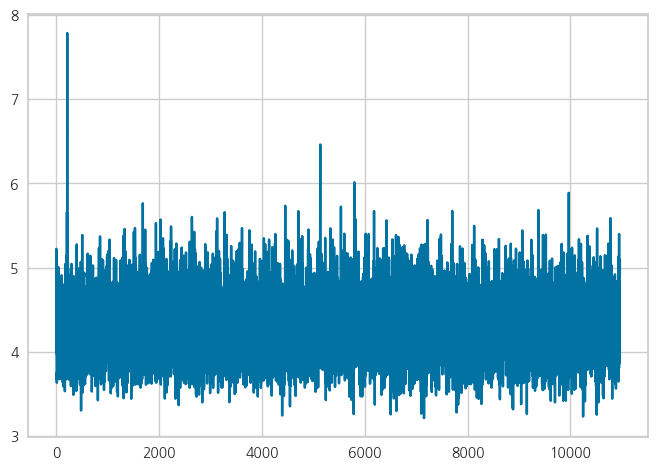

In [119]:
plt.plot(pd.read_csv('./hu-gr-lgb.csv')['ECLO'])

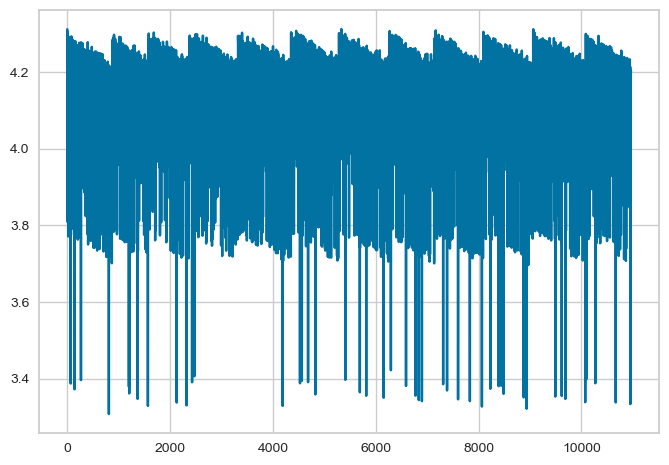

In [40]:
plt.plot(pd.read_csv('./huber-0.4496.csv')['ECLO'])

In [98]:
target = '사망자수'


light_df = pd.read_csv('./open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])
light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

child_area_df = pd.read_csv('./open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()# [['소재지지번주소']]
child_area_df['시설수'] = 1
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

parking_df = pd.read_csv('./open/external_open/대구 주차장 정보.csv', encoding='cp949')
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
parking_df = parking_df.groupby(['도시', '구', '동']).mean().reset_index()
parking_df.reset_index(inplace=True, drop=True)
parking_df = parking_df.fillna(0)

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

cols = list(test.columns)
cols.append(target)
train = train[cols]

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 
train[['연', '월', '일', '시간']] = train['사고일시'].str.extract(time_pattern)
train[['연', '월', '일', '시간']] = train[['연', '월', '일', '시간']].apply(pd.to_numeric) 
train = train.drop(columns=['사고일시'])
test[['연', '월', '일', '시간']] = test['사고일시'].str.extract(time_pattern)
test[['연', '월', '일', '시간']] = test[['연', '월', '일', '시간']].apply(pd.to_numeric)
test = test.drop(columns=['사고일시'])

location_pattern = r'(\S+) (\S+) (\S+)'
train[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
train = train.drop(columns=['시군구'])
test[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
test = test.drop(columns=['시군구'])

road_pattern = r'(.+) - (.+)'
train[['도로형태1', '도로형태2']] = train['도로형태'].str.extract(road_pattern)
train = train.drop(columns=['도로형태'])

test[['도로형태1', '도로형태2']] = test['도로형태'].str.extract(road_pattern)
test = test.drop(columns=['도로형태'])

# train = pd.merge(train, light_df, how='left', on=['도시', '구', '동'])
# train = pd.merge(train, child_area_df, how='left', on=['도시', '구', '동'])
# train = pd.merge(train, parking_df, how='left', on=['도시', '구', '동'])

# test = pd.merge(test, light_df, how='left', on=['도시', '구', '동'])
# test = pd.merge(test, child_area_df, how='left', on=['도시', '구', '동'])
# test = pd.merge(test, parking_df, how='left', on=['도시', '구', '동'])

train = train.drop(['ID','도시'],axis=1)
test = test.drop(['ID','도시'],axis=1)
# train = train.dropna()

train = train.fillna(0)
test = test.fillna(0)

# train = train[train['ECLO'] <= 40]
train = train.reset_index(drop=True)
categorical_features = list(train.dtypes[train.dtypes == "object"].index)
for i in categorical_features:
    le = LabelEncoder()
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])
    
train


,요일,기상상태,노면상태,사고유형,사망자수,연,월,일,시간,구,동,도로형태1,도로형태2
0,6,2,0,0,0,2019,1,1,0,7,40,2,5
1,6,5,0,0,0,2019,1,1,0,1,4,2,5
2,6,2,0,0,0,2019,1,1,1,6,66,2,5
3,6,2,0,1,0,2019,1,1,2,4,79,2,5
4,6,2,0,1,0,2019,1,1,4,3,129,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,2,0,1,0,2021,12,31,19,6,118,0,3
39605,0,2,0,1,0,2021,12,31,19,1,103,2,5
39606,0,2,0,1,0,2021,12,31,21,1,144,0,3
39607,0,2,0,1,0,2021,12,31,22,1,158,1,5


In [104]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from pycaret import regression
from pycaret import classification

target = '사망자수'
X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[target], test_size=0.2, random_state=42)

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = result.importances_mean

tp = {i:feature_importance[i] for i in range(len(feature_importance))}
sorted_dict = dict(sorted(tp.items(), key=lambda item: item[1], reverse=True))
sorted_dict

ratio = 0.8
k = int(len(train.drop(target,axis=1).columns)*ratio)
selected_features = list(sorted_dict.keys())[:k]

classification.setup(data=train.drop(target,axis=1).iloc[:,selected_features],target=train[target]
                     ,train_size=0.8
                     ,fold=10
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
                     ,verbose=200)
best = classification.compare_models(sort='Accuracy',n_select=4)


,Description,Value
0,Session id,42
1,Target,사망자수
2,Target type,Multiclass
3,Original data shape,"(39609, 10)"
4,Transformed data shape,"(39609, 10)"
5,Transformed train set shape,"(31687, 10)"
6,Transformed test set shape,"(7922, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:50:43
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)



KeyboardInterrupt



In [103]:
best[0].predict(test.iloc[:,selected_features])

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

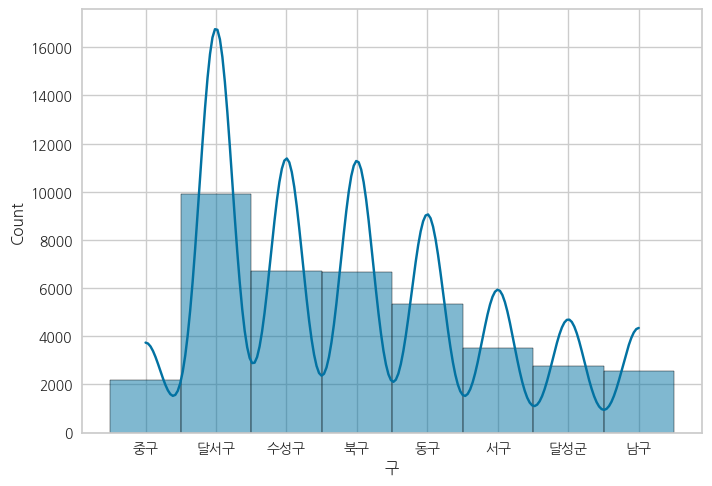

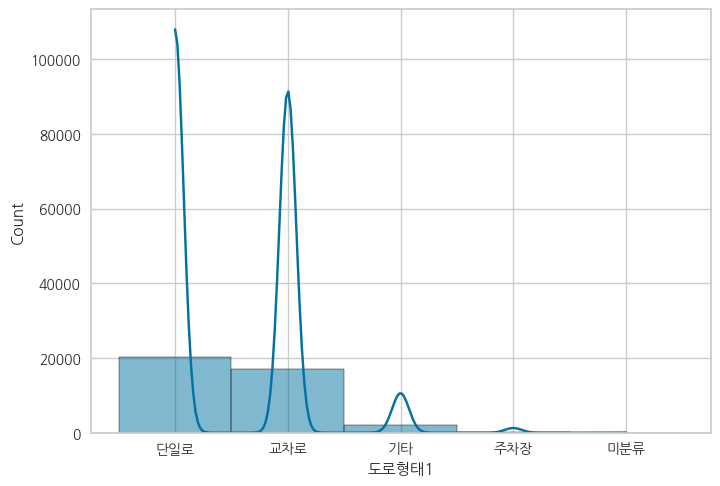

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 나눔 폰트 경로 설정 (설치된 폰트 경로에 따라 변경)
font_path = './나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'

# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

# Matplotlib에서 한글 폰트로 지정
rc('font', family=font_name)

# 특정 컬럼에 따라 데이터 구분하고 히스토그램 그리기
sns.histplot(data=train, x='구', kde=True, bins=20)
plt.show()
sns.histplot(data=train, x='도로형태1', kde=True, bins=20)
plt.show()